In [ ]:
# fix python path if working locally
from helpers import fix_pythonpath_if_working_locally
fix_pythonpath_if_working_locally()

import requests
import io
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import datetime as dt

from darts import TimeSeries
from darts.models import (
    BlockRNNModel,
)
from darts.utils.missing_values import fill_missing_values
from sklearn.preprocessing import MinMaxScaler
from darts.dataprocessing.transformers import Scaler

# for reproducibility
torch.manual_seed(1)
np.random.seed(1)


In [2]:
# Importing Training Set
def loadDataset(url):
    s=requests.get(url).content
    dataset = data=pd.read_csv(io.StringIO(s.decode('utf-8')))
    dataset.livingroom_window_open = dataset.livingroom_window_open.replace({True: 1, False: 0})
    dataset.livingroom_door_open = dataset.livingroom_window_open.replace({True: 1, False: 0})
    dataset.balcony_door_open = dataset.livingroom_door_open.replace({True: 1, False: 0})
    dataset.kitchen_window_open = dataset.kitchen_window_open.replace({True: 1, False: 0})
    dataset.timestamp = pd.Series([dt.datetime.strptime(date, '%Y-%m-%dT%H:%M:%S.%fZ') for date in list(dataset['timestamp'])]).round("10S")

    # Select features (columns) to be involved intro training and predictions
    cols = ["timestamp", "co2", "livingroom_window_open", "livingroom_door_open", "balcony_door_open", "kitchen_window_open", "rtemperature", "rhumidity", "temperature_outdoor", "humidity_outdoor"]
    return dataset[cols].drop_duplicates(subset=['timestamp'], keep='last')

In [3]:
model_co2 = BlockRNNModel.load_model('co2_gru_90x90x50.pth.tar')

/Users/manuelberger/Documents/dev/github/indoor-air-monitor/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


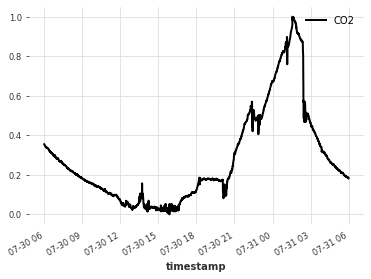

In [55]:
dataset = loadDataset("https://iaq-data.brgr.rocks/day.csv")

# series to predict, in this case CO2
series_co2 = fill_missing_values(TimeSeries.from_dataframe(dataset, 'timestamp', 'co2', fill_missing_dates=True, freq="10s" ), fill='auto')

# covariates to help predict the CO2 series
covariates_livingroom_door_open = fill_missing_values(TimeSeries.from_dataframe(dataset, 'timestamp', 'livingroom_door_open', fill_missing_dates=True, freq="10s"), fill='auto')
covariates_balcony_door_open = fill_missing_values(TimeSeries.from_dataframe(dataset, 'timestamp', 'balcony_door_open', fill_missing_dates=True, freq="10s"), fill='auto')
covariates_livingroom_window_open = fill_missing_values(TimeSeries.from_dataframe(dataset, 'timestamp', 'livingroom_window_open', fill_missing_dates=True, freq="10s"), fill='auto')
covariates_kitchen_window_open = fill_missing_values(TimeSeries.from_dataframe(dataset, 'timestamp', 'kitchen_window_open', fill_missing_dates=True, freq="10s"), fill='auto')
covariates_temperature_indoors = fill_missing_values(TimeSeries.from_dataframe(dataset, 'timestamp', 'rtemperature', fill_missing_dates=True, freq="10s"), fill='auto')
covariates_humidity_indoors = fill_missing_values(TimeSeries.from_dataframe(dataset, 'timestamp', 'rhumidity', fill_missing_dates=True, freq="10s"), fill='auto')
covariates_temperature_outdoors = fill_missing_values(TimeSeries.from_dataframe(dataset, 'timestamp', 'temperature_outdoor', fill_missing_dates=True, freq="10s"), fill='auto')
covariates_humidity_outdoors = fill_missing_values(TimeSeries.from_dataframe(dataset, 'timestamp', 'humidity_outdoor', fill_missing_dates=True, freq="10s"), fill='auto')

scaler = Scaler()
scaler_covariates = Scaler()
series_co2_scaled = scaler.fit_transform(series_co2)

covariates_livingroom_door_open_scaled, covariates_balcony_door_open_scaled, covariates_livingroom_window_open_scaled, covariates_kitchen_window_open_scaled, covariates_temperature_indoors_scaled, covariates_humidity_indoors_scaled, covariates_temperature_outdoors_scaled, covariates_humidity_outdoors_scaled = scaler_covariates.fit_transform([covariates_livingroom_door_open, covariates_balcony_door_open, covariates_livingroom_window_open, covariates_kitchen_window_open, covariates_temperature_indoors, covariates_humidity_indoors, covariates_temperature_outdoors, covariates_humidity_outdoors])

all_covariates_scaled = covariates_livingroom_door_open_scaled.stack(covariates_balcony_door_open_scaled).stack(covariates_livingroom_window_open_scaled).stack(covariates_kitchen_window_open_scaled).stack(covariates_temperature_indoors_scaled).stack(covariates_humidity_indoors_scaled).stack(covariates_temperature_outdoors_scaled).stack(covariates_humidity_outdoors_scaled)
series_co2_scaled.plot(label="CO2")
plt.legend()


/Users/manuelberger/Documents/dev/github/indoor-air-monitor/venv/lib/python3.8/site-packages/pytorch_lightning/loops/utilities.py:92: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
2022-08-01 02:27:21 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2022-08-01 02:27:21 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-08-01 02:27:21 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-08-01 02:27:21 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
/Users/manuelberger/Documents/dev/github/indoor-air-monitor/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` 

Predicting: 0it [00:00, ?it/s]

755.3708134781693


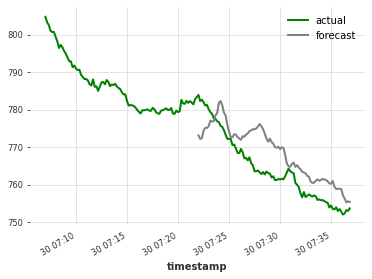

In [57]:
from pytorch_lightning import Trainer

position = 400
past = 90

past_series_co2_part = series_co2_scaled[position:(position+past)]
past_covariates_part = all_covariates_scaled[position:(position+past)]

actual_co2 = series_co2_scaled[position:(position+past*2)]

pred_list_scaled = model_co2.predict(n=past, series=past_series_co2_part, past_covariates=past_covariates_part, trainer=Trainer(accelerator="cpu"))

pred_list = scaler.inverse_transform(pred_list_scaled)
series_air = scaler.inverse_transform(series_co2_scaled)
series_actual = scaler.inverse_transform(actual_co2)

series_actual.plot(label="actual", color="green")
pred_list.plot(label="forecast", color="grey")
print(pred_list.last_value())
plt.legend()

In [10]:
from darts import metrics

historical_fcast = model_co2.historical_forecasts(
 series=past_series_co2_part, past_covariates=past_covariates_part, start=90, forecast_horizon=90, verbose=False, retrain=False, overlap_end=False
)

series_co2_real = scaler.inverse_transform(past_series_co2_part[180:])
historical_fcast_real = scaler.inverse_transform(historical_fcast)

series_co2_real.plot(label="actual")
historical_fcast_real.plot(label="predicted")

print(metrics.metrics.mae(series_co2_real, historical_fcast_real))

2022-08-01 02:00:32 darts.timeseries ERROR: ValueError: point (int) should be a valid index in series


ValueError: point (int) should be a valid index in series